In [1]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import matplotlib.pyplot as plt

In [2]:
DATA_DIR = '../../data/data_clean.csv'

In [3]:
df = pd.read_csv(DATA_DIR)

In [4]:
df.columns

Index(['Source.Name', 'date', 'hour', 'type', '北京', '天津', '石家庄', '唐山', '秦皇岛',
       '邯郸', '保定', '张家口', '承德', '廊坊', '沧州', '衡水', '邢台', 'tag'],
      dtype='object')

In [5]:
df = df.drop(['Source.Name','date','hour','tag'],axis=1)

In [6]:
df

,type,北京,天津,石家庄,唐山,秦皇岛,邯郸,保定,张家口,承德,廊坊,沧州,衡水,邢台
0,O3_24h,50.0,52.0,57.0,61.0,60.0,45.0,67.0,64.0,76.0,44.0,60.0,66.0,46.0
1,NO2_24h,63.0,57.0,76.0,63.0,47.0,67.0,62.0,26.0,42.0,33.0,58.0,68.0,61.0
2,SO2_24h,32.0,65.0,121.0,52.0,53.0,176.0,157.0,76.0,37.0,37.0,99.0,70.0,152.0
3,PM2.5_24h,51.0,65.0,141.0,61.0,42.0,140.0,181.0,33.0,35.0,57.0,71.0,108.0,142.0
4,O3_24h,50.0,52.0,57.0,61.0,60.0,45.0,67.0,64.0,76.0,44.0,60.0,66.0,46.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
247004,PM2.5_24h,14.0,31.0,30.0,30.0,18.0,38.0,26.0,13.0,17.0,20.0,30.0,29.0,33.0
247005,O3_24h,92.0,123.0,114.0,113.0,112.0,130.0,121.0,104.0,105.0,133.0,117.0,120.0,123.0
247006,NO2_24h,23.0,31.0,37.0,21.0,21.0,19.0,42.0,11.0,25.0,20.0,21.0,25.0,23.0
247007,SO2_24h,2.0,9.0,6.0,7.0,6.0,8.0,6.0,3.0,11.0,4.0,11.0,10.0,6.0


In [7]:
O3 = df[df['type']=='O3_24h'].drop('type',axis=1)

In [8]:
O3['label'] = O3['北京'].shift(-15)

In [9]:
O3 = O3.dropna()

In [10]:
df = O3

In [11]:
df.shape

(60932, 14)

In [12]:
split_fraction = 0.9
train_split = int(split_fraction * int(df.shape[0]))
step = 1

past = 200
future = 15
learning_rate = 0.00001
batch_size = 256
epochs = 50


In [13]:

def normalize(data, train_split):
    data_mean = data[:train_split].mean(axis=0)
    data_std = data[:train_split].std(axis=0)
    return (data - data_mean) / data_std


In [14]:
features = df.drop(['label'],axis=1)
features = normalize(features.values, train_split)
features = pd.DataFrame(features)
features.head()

train_data = features.loc[0 : train_split - 1]
val_data = features.loc[train_split:]

In [15]:
start = past + future
end = start + train_split

x_train = train_data.values
y_train = features.iloc[start:end][[1]]

sequence_length = 200

In [16]:

dataset_train = keras.preprocessing.timeseries_dataset_from_array(
    x_train,
    y_train,
    sequence_length=sequence_length,
    # sampling_rate=step,
    batch_size=batch_size,
)

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2022-05-08 19:57:02.040541: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-05-08 19:57:02.040657: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [17]:
x_end = len(val_data) - past - future

label_start = train_split + past + future

x_val = val_data.iloc[:x_end,:].values
y_val = features.iloc[label_start:][[1]]

dataset_val = keras.preprocessing.timeseries_dataset_from_array(
    x_val,
    y_val,
    sequence_length=sequence_length,
    # sampling_rate=step,
    batch_size=batch_size,
)


for batch in dataset_val.take(1):
    inputs, targets = batch

print("Input shape:", inputs.numpy().shape)
print("Target shape:", targets.numpy().shape)

Input shape: (256, 200, 13)
Target shape: (256, 1)


2022-05-08 19:57:02.127962: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz


In [18]:
inputs = keras.layers.Input(shape=(inputs.shape[1], inputs.shape[2]))
lstm_out = keras.layers.LSTM(32)(inputs)
outputs = keras.layers.Dense(1)(lstm_out)

model = keras.Model(inputs=inputs, outputs=outputs)
model.compile(optimizer=keras.optimizers.Adam(learning_rate=learning_rate), loss="mse")
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 200, 13)]         0         
                                                                 
 lstm (LSTM)                 (None, 32)                5888      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 5,921
Trainable params: 5,921
Non-trainable params: 0
_________________________________________________________________


In [19]:
path_checkpoint = "model_checkpoint.h5"
es_callback = keras.callbacks.EarlyStopping(monitor="val_loss", min_delta=0, patience=5)
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir="./logs")
modelckpt_callback = keras.callbacks.ModelCheckpoint(
    monitor="val_loss",
    filepath=path_checkpoint,
    verbose=1,
    save_weights_only=True,
    save_best_only=True,
)

history = model.fit(
    dataset_train,
    epochs=epochs,
    validation_data=dataset_val,
    callbacks=[es_callback, modelckpt_callback,tensorboard_callback],
)

Epoch 1/50


2022-05-08 19:57:02.901815: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-08 19:57:03.034986: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-08 19:57:03.452802: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


214/214 [==============================] - ETA: 0s - loss: 0.9235

2022-05-08 19:57:18.422246: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-08 19:57:18.468781: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.



Epoch 1: val_loss improved from inf to 0.49402, saving model to model_checkpoint.h5
214/214 [==============================] - 17s 73ms/step - loss: 0.9235 - val_loss: 0.4940
Epoch 2/50
213/214 [============================>.] - ETA: 0s - loss: 0.8412
Epoch 2: val_loss improved from 0.49402 to 0.43825, saving model to model_checkpoint.h5
214/214 [==============================] - 14s 64ms/step - loss: 0.8398 - val_loss: 0.4383
Epoch 3/50
214/214 [==============================] - ETA: 0s - loss: 0.7659
Epoch 3: val_loss improved from 0.43825 to 0.38901, saving model to model_checkpoint.h5
214/214 [==============================] - 14s 65ms/step - loss: 0.7659 - val_loss: 0.3890
Epoch 4/50
213/214 [============================>.] - ETA: 0s - loss: 0.7014
Epoch 4: val_loss improved from 0.38901 to 0.34572, saving model to model_checkpoint.h5
214/214 [==============================] - 14s 64ms/step - loss: 0.7003 - val_loss: 0.3457
Epoch 5/50
213/214 [============================>.] - ET

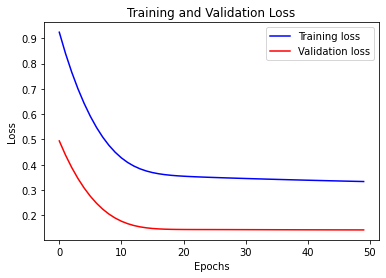

In [20]:

def visualize_loss(history, title):
    loss = history.history["loss"]
    val_loss = history.history["val_loss"]
    epochs = range(len(loss))
    plt.figure()
    plt.plot(epochs, loss, "b", label="Training loss")
    plt.plot(epochs, val_loss, "r", label="Validation loss")
    plt.title(title)
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend()
    plt.show()


visualize_loss(history, "Training and Validation Loss")

In [21]:

def show_plot(plot_data, delta, title):
    labels = ["History", "True Future", "Model Prediction"]
    marker = [".-", "rx", "go"]
    time_steps = list(range(-(plot_data[0].shape[0]), 0))
    if delta:
        future = delta
    else:
        future = 0

    plt.title(title)
    for i, val in enumerate(plot_data):
        if i:
            plt.plot(future, plot_data[i], marker[i], markersize=10, label=labels[i])
        else:
            plt.plot(time_steps, plot_data[i].flatten(), marker[i], label=labels[i])
    plt.legend()
    plt.xlim([time_steps[0], (future + 5) * 2])
    plt.xlabel("Time-Step")
    plt.show()
    return



2022-05-08 20:09:03.108469: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-08 20:09:03.145190: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


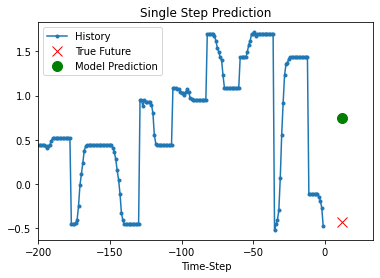

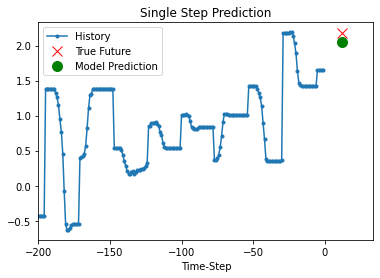

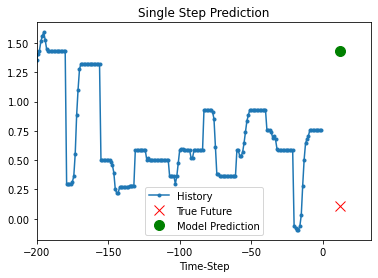

In [22]:

for x, y in dataset_val.take(3):
    show_plot(
        [x[0][:, 1].numpy(), y[0].numpy(), model.predict(x)[0]],
        12,
        "Single Step Prediction",
    )

In [23]:
y_val.shape

(5879, 1)

In [24]:
x_val.shape

(5879, 13)

In [25]:
pred = model.predict(dataset_val)

2022-05-08 20:09:04.480259: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-05-08 20:09:04.526764: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


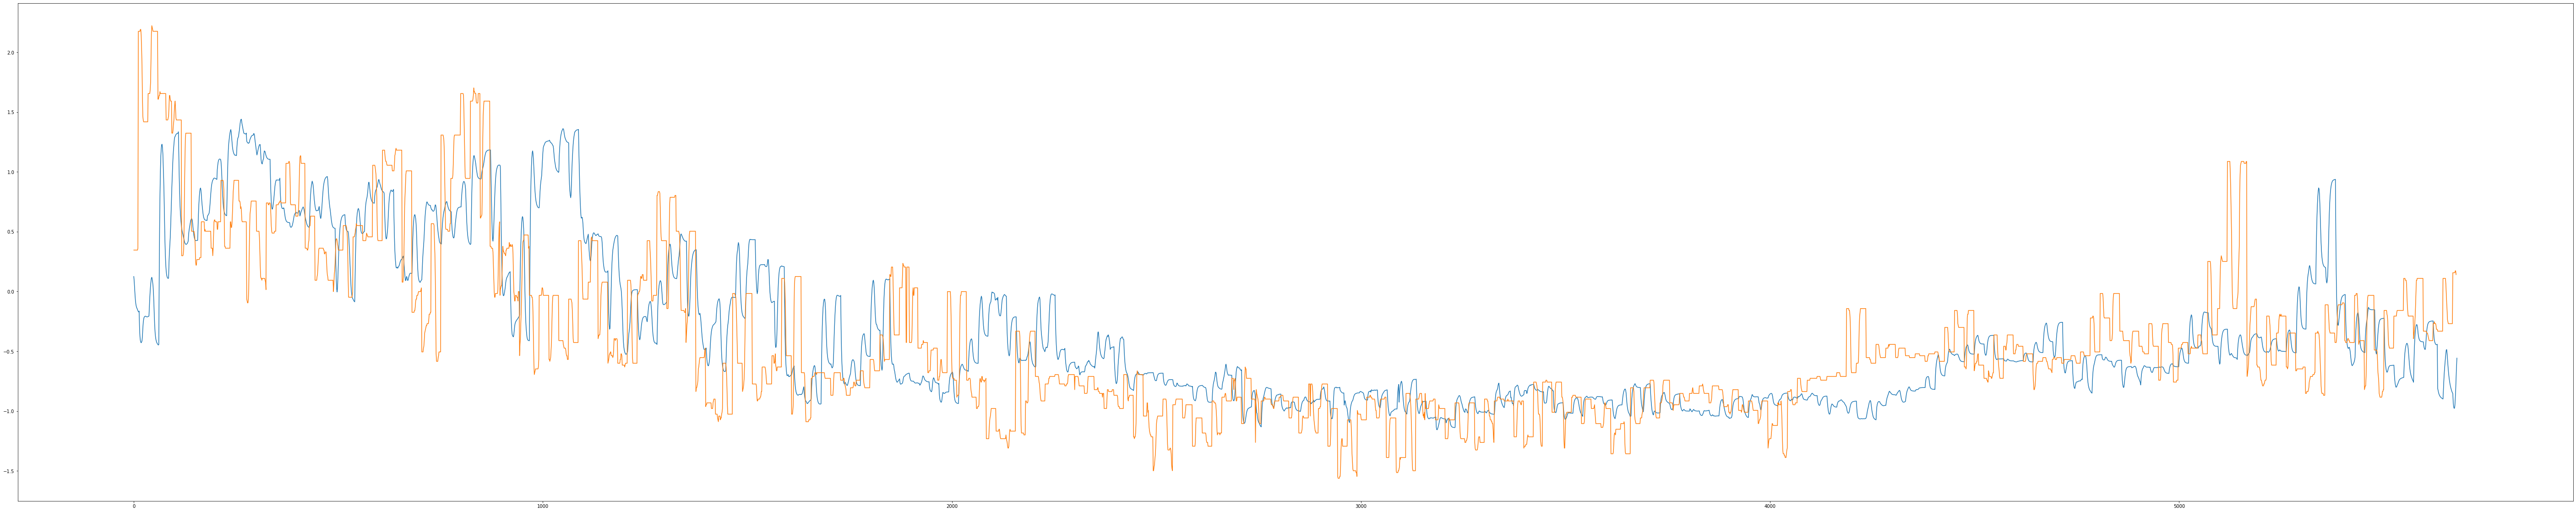

In [26]:
plt.figure(figsize=(100, 20))
plt.plot(pred)
plt.plot(y_val.values[201:])